In [1]:
import os
from pathlib import Path

cwd = Path.cwd()
if cwd.name == "notebooks":
    os.chdir(cwd.parent)

In [2]:
import numpy as np
import pandas as pd
from mllm_emotion_classifier.utils import (
    FigureCollector,
    quantile_binning,
    plot_global_over_attribute_values,
    plot_classwise_over_attribute_values,
    plot_classwise_heatmap,
)
from EmoBox.EmoBox import EmoDataset

In [3]:
dataset2name = {
    "cremad": "CREMA-D",
    "iemocap": "IEMOCAP",
    "emovdb": "EmoV-DB",
    "tess"  : "TESS",
    "ravdess": "RAVDESS",
    "esd": "ESD",
    "meld": "MELD",
}

dataset2bins = {
    'cremad': {'age': 4},
    'meld': {'age': 3},
}

In [4]:
hparam = 'temperature' # or 'top_p'
assert hparam in ['temperature', 'top_p'], "hparam must be either 'temperature' or 'top_p'"

dataset = 'meld'  # 'cremad', 'iemocap', 'emovdb'
fold = None # Set to an integer fold number if needed, else None to aggregate all folds
sensitive_attr = 'gender' # gender, age, ethnicity, race
model = 'qwen2-audio-instruct'

metadata_dir = Path('EmoBox/data/')
dataset_path = metadata_dir / dataset
n_folds = len([d for d in dataset_path.iterdir() if d.is_dir() and d.name.startswith("fold_")])
out_dir = Path('outputs-2') / "temperature_runs" if hparam == 'temperature' else Path('outputs-2') / "topp_runs"

test = EmoDataset(dataset, './', metadata_dir, fold=1, split="test")
emotions = set(test.label_map.values())

if fold is None:
    dfs = []
    for f in range(1, n_folds + 1):
        results_csv = out_dir / model / dataset / f'fold_{f}.csv'
        df_fold = pd.read_csv(results_csv)
        dfs.append(df_fold)
    df = pd.concat(dfs, ignore_index=True)
else:
    results_csv = out_dir / model / dataset / f'fold_{fold}.csv'
    df = pd.read_csv(results_csv)

print(len(df), "rows")
df.head(5)

using official valid data in EmoBox/data/meld/fold_1/meld_valid_fold_1.jsonl
load in 9988 samples, only 9988 exists in data dir EmoBox/data
load in 2610 samples, only 2156 exists in data dir EmoBox/data
load in 1108 samples, only 952 exists in data dir EmoBox/data
Num. training samples 9988
Num. valid samples 952
Num. test samples 2156
Using label_map {'neutral': 'Neutral', 'joy': 'Happy', 'sadness': 'Sad', 'surprise': 'Surprise', 'disgust': 'Disgust', 'anger': 'Angry', 'fear': 'Fear'}
60 rows


,run,dataset,fold,model,prompt,temperature,valid_rate,global_f1_macro,global_f1_weighted,global_accuracy_unweighted,...,language_statistical_parity,language_Angry_equal_opportunity,language_Disgust_equal_opportunity,language_Fear_equal_opportunity,language_Happy_equal_opportunity,language_Neutral_equal_opportunity,language_Sad_equal_opportunity,language_Surprise_equal_opportunity,language_equal_opportunity,language_overall_accuracy_equality
0,0,meld,1,qwen2-audio-instruct,user_labels,0.0001,1.0,0.2576,0.3789,0.3450,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,meld,1,qwen2-audio-instruct,user_labels,0.3000,1.0,0.3037,0.4340,0.4097,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,meld,1,qwen2-audio-instruct,user_labels,0.7000,1.0,0.2578,0.3235,0.3594,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,meld,1,qwen2-audio-instruct,user_labels,1.0000,1.0,0.2522,0.4043,0.3075,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,meld,1,qwen2-audio-instruct,user_labels,1.2000,1.0,0.2079,0.3414,0.2703,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
if hparam == 'top_p':
    best_row = df.loc[df['global_f1_macro'].idxmax()]
    best_top_p = best_row['top_p']
    print("Best top_p:", best_top_p)
else:
    best_row = df.loc[df['global_f1_macro'].idxmax()]
    best_temperature = best_row['temperature']
    print("Best temperature:", best_temperature)

Best temperature: 0.0001


In [6]:
# test[0]

In [7]:
# fold = fold if fold is not None else 'all'
# os.makedirs(out_dir / 'figures', exist_ok=True)

# for key in test[0]:
#     if key in ['key', 'audio', 'label', 'transcript', 'language']:
#         continue
    
#     attribute = key
#     outpath = out_dir / 'figures' / f'{dataset}_{attribute}_bar_fold_{fold}.png'
#     values = np.array([sample[key] for sample in test])
#     attribute_values = list(set(values))
#     if attribute in ['age']:
#         attribute_values = set(quantile_binning(values, n_bins=4))
#     # with FigureCollector() as collector:
#     plot_global_over_attribute_values(df, 0.0001, attribute=attribute, attribute_values=attribute_values, metric='f1_macro', temperature=hparam=='temperature', model=model, dataset=dataset2name[dataset], fold=fold, outpath=outpath)
#         # plot_global_over_attribute_values(df, 0.0001, attribute=attribute, attribute_values=attribute_values, metric='f1_weighted', model=model, dataset=dataset, fold=fold)
#         # plot_global_over_attribute_values(df, 0.0001, attribute=attribute, attribute_values=attribute_values, metric='accuracy_unweighted', model=model, dataset=dataset, fold=fold)
#         # plot_global_over_attribute_values(df, 0.0001, attribute=attribute, attribute_values=attribute_values, metric='accuracy_weighted', model=model, dataset=dataset, fold=fold)
        
#     # collector.display_grid(nrows=1, ncols=4, figsize=(20, 18))

  0%|                                                                                                                                                               | 0/2156 [00:00<?, ?it/s]

/nfs/home/dasaro/research/FairMLLM-Emotion-Recognition/EmoBox/EmoBox/EmoDataset.py:191: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, sr = librosa.load(wav_path, sr=None, mono=False)
/nfs/home/dasaro/research/FairMLLM-Emotion-Recognition/.venv/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  0%|                                                                                                                                                     | 1/2156 [00:01<1:05:00,  1.81s/it]/nfs/home/dasaro/research/FairMLLM-Emotion-Recognition/EmoBox/EmoBox/EmoDataset.py:191: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, sr = librosa.load(wav_path, sr=None, mono=False)
/nfs/home/dasaro/research/FairMLLM-Emotion-Recognition/.venv/lib/python3.10/site-packa

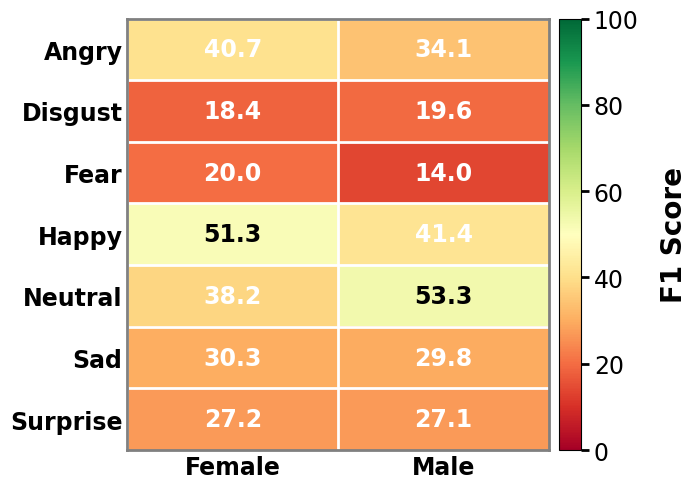

  24-29: 524 (24.3%)
  29-33: 907 (42.1%)
  33-39: 725 (33.6%)


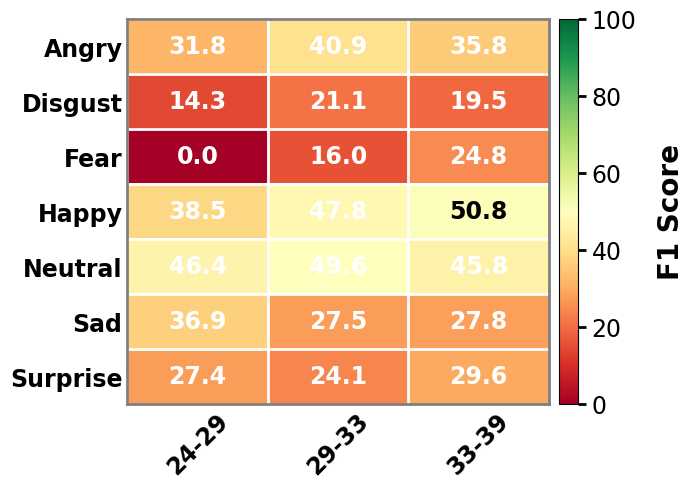

In [8]:
from tqdm import tqdm

attribute_data = {}
for sample in tqdm(test):
    for key in sample:
        if key in ['key', 'audio', 'label', 'transcript', 'language']:
            continue
        if key not in attribute_data:
            attribute_data[key] = []
        attribute_data[key].append(sample[key])

# Convert to numpy arrays and get unique values
fold = fold if fold is not None else 'all'
os.makedirs(out_dir / 'figures', exist_ok=True)

for attribute, values in attribute_data.items():
    values = np.array(values)
    attribute_values = list(set(values))
    
    if attribute in ['age'] and dataset in dataset2bins and attribute in dataset2bins[dataset]:
        n_bins = dataset2bins[dataset][attribute]
        attribute_values = set(quantile_binning(values, n_bins=n_bins))
    
    outpath = out_dir / 'figures' / f'{dataset}_{attribute}_heatmap_fold_{fold}.png'
    
    plot_classwise_heatmap(
        df, 0.0001, emotions, 
        attribute=attribute, 
        attribute_values=attribute_values, 
        metric='f1_score', 
        temperature=hparam=='temperature', 
        model=model, 
        dataset=dataset2name[dataset], 
        fold=fold, 
        outpath=outpath
    )